# Einsum decomposition

This notebook shows a way to decompose [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) into a subset of operations (expand_dims, squeeze, transpose, extended matrix multiplication).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## Operator explanation with equation bac,cd,def->ebc

The operator einsum takes an equation and some inputs. Every letter involved in the equation is a loop. Let's see on one example.

In [3]:
import numpy

m1 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 10
m2 = numpy.arange(0, 4).astype(numpy.float32).reshape((2, 2)) + 100
m3 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 1000

equation = "bac,cd,def->ebc"
truth = numpy.einsum(equation, m1, m2, m3)
truth

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

This summation is equalent to:

In [4]:
res = numpy.zeros((2, 2, 2))
for a in range(0, 2):
    for b in range(0, 2):
        for c in range(0, 2):
            for d in range(0, 2):
                for e in range(0, 2):
                    for f in range(0, 2):
                        res[e, b, c] += m1[b, a, c] * m2[c, d] * m3[d, e, f]
res

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]])

Theoritically, this summation is in this case has a cost of $O(N^6)$. However this simple computation is usually much longer than using matrix multiplications along the path. $O(N^4)$ is the cost of the heaviest matrix multiplication in this case). But to do that, the equation needs to be decomposed into a sequence of matrix multiplications.

### Decomposition of bac,cd,def->ebc

In [5]:
import numpy
from mlprodict.testing.einsum_impl import (
    decompose_einsum_equation, apply_einsum_sequence)

In [6]:
m1 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 10
m2 = numpy.arange(0, 4).astype(numpy.float32).reshape((2, 2)) + 100
m3 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 1000

In [7]:
seq = decompose_einsum_equation("bac,cd,def->ebc")

In [8]:
from jyquickhelper import RenderJsDot
RenderJsDot(seq.to_dot(size=7))

Then the result can be obtained as follows:

In [9]:
apply_einsum_sequence(seq, m1, m2, m3)

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

### operator matmul

This operator can be used to represent either a multiplication, either a matrix multiplication but it applies only on arrays with the same number of dimensions. It can be broken into multiplication of matrix multiplication.

In [10]:
seq_clean = decompose_einsum_equation("bac,cd,def->ebc", strategy='numpy', clean=True)
RenderJsDot(seq_clean.to_dot(size=7))

Operator *transpose_mm* is a regular transposition, it takes two inputs but only tranposes the first input before returning it. Operator *batch_dot* is a matrix multiplication. It is left that way on purpose as it may be implemented with function dot or gemm. The operator distinguishes between 3 kind of axes: batch axes, kept axes, sum(mation) axes. It then reshapes both input matrices with 3D tensors, batch axis, row axis, column axis to use function [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).

### ONNX

The previous graph can be converted into ONNX.

In [11]:
onx = seq_clean.to_onnx("Y", "X1", "X2", "X3", dtype=numpy.float32)
# with open("einsum.onnx", "wb") as f:
#      f.write(onx.SerializeToString())
%onnxview onx 

In [12]:
from onnxruntime import InferenceSession
sess = InferenceSession(onx.SerializeToString())
sess.run(None, {'X1': m1.astype(numpy.float32), 
                'X2': m2.astype(numpy.float32), 
                'X3': m3.astype(numpy.float32)})[0]

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

### onnxruntime

In [13]:
import onnx
from onnx import helper, numpy_helper
from onnxruntime import InferenceSession


def make_model1(equation):
    model = helper.make_model(
        opset_imports=[helper.make_operatorsetid('', 13)],
        graph=helper.make_graph(
            name='einsum_test',
            inputs=[helper.make_tensor_value_info("X", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Y", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Z", onnx.TensorProto.FLOAT, None)],
            outputs=[helper.make_tensor_value_info("A", onnx.TensorProto.FLOAT, None)],
            nodes=[
                helper.make_node("Einsum", ["X", "Y", "Z"], ["A"], equation=equation)
            ]
        )
    )
    return model


model = make_model1("bac,cd,def->ebc")
sess = InferenceSession(model.SerializeToString())

In [14]:
sess.run(None, {'X': m1.astype(numpy.float32), 
                'Y': m2.astype(numpy.float32), 
                'Z': m3.astype(numpy.float32)})[0]

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

### Benchmark

It clearly shows the summation done with the basic algorithm is the slowest.

In [15]:
from mlprodict.onnxrt.validate.validate_helper import measure_time
from tqdm import tqdm
from pandas import DataFrame


def raw_product(m1, m2, m3):
    N = m1.shape[0]
    res = numpy.zeros((N, N, N))
    for a in range(0, N):
        for b in range(0, N):
            for c in range(0, N):
                for d in range(0, N):
                    for e in range(0, N):
                        for f in range(0, N):
                            res[e, b, c] += m1[b, a, c] * m2[c, d] * m3[d, e, f]
    return res


equation = "bac,cd,def->ebc"
sess = None
sess2 = None
seq = None 
seq2 = None 

results = []
for N in tqdm([2, 3, 4, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]):
    m1 = numpy.random.randn(N, N, N)
    m2 = numpy.random.randn(N, N)
    m3 = numpy.random.randn(N, N, N)
    
    if seq is None:
        seq = decompose_einsum_equation(equation, clean=True)
    if seq2 is None:
        seq2 = decompose_einsum_equation(equation, clean=True, strategy='numpy')
    if sess is None:
        model = make_model1(equation)
        sess = InferenceSession(model.SerializeToString())
    if sess2 is None:
        onx = seq2.to_onnx("Y", "X1", "X2", "X3", dtype=numpy.float32)
        sess2 = InferenceSession(onx.SerializeToString())

    res = measure_time(lambda x: numpy.einsum(equation, *x, optimize=True),
                       [m1, m2, m3],
                       repeat=10, number=10)

    res['name'] = "numpy.einsum"
    res["N"] = N
    results.append(res)

    if N <= 4:
        res = measure_time(lambda x: raw_product(*x),
                           [m1, m2, m3],
                           repeat=10, number=10)
        res['name'] = "raw_product"
        res["N"] = N
        results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq, *x),
                       [m1, m2, m3],
                       repeat=10, number=10)

    res['name'] = "custom_einsum"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq, *x, matmul_impl="pyf"),
                       [m1, m2, m3],
                       repeat=10, number=10)
    res['name'] = "dec-matmul"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq2, *x, matmul_impl="pyf"),
                       [m1, m2, m3],
                       repeat=10, number=10)
    res['name'] = "dec-batch_dot"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: sess.run(None, {'X': x[0], 'Y': x[1], 'Z': x[2]}),
                       [m1.astype(numpy.float32), m2.astype(numpy.float32),
                        m3.astype(numpy.float32)],
                       repeat=10, number=10)
    res['name'] = "ort-einsum"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: sess2.run(None, {'X1': x[0], 'X2': x[1], 'X3': x[2]}),
                       [m1.astype(numpy.float32), m2.astype(numpy.float32),
                        m3.astype(numpy.float32)],
                       repeat=10, number=10)
    res['name'] = "ort-matmul"
    res["N"] = N
    results.append(res)    
    

df = DataFrame(results)
df.tail()

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N
82,0.062646,0.000681,0.062002,0.063933,10,10,0.626458,custom_einsum,60
83,0.048764,0.001461,0.047808,0.052906,10,10,0.487644,dec-matmul,60
84,0.040966,0.000602,0.040169,0.041773,10,10,0.409658,dec-batch_dot,60
85,0.010761,0.000982,0.009832,0.012314,10,10,0.107609,ort-einsum,60
86,0.015497,0.000365,0.014887,0.015853,10,10,0.154967,ort-matmul,60


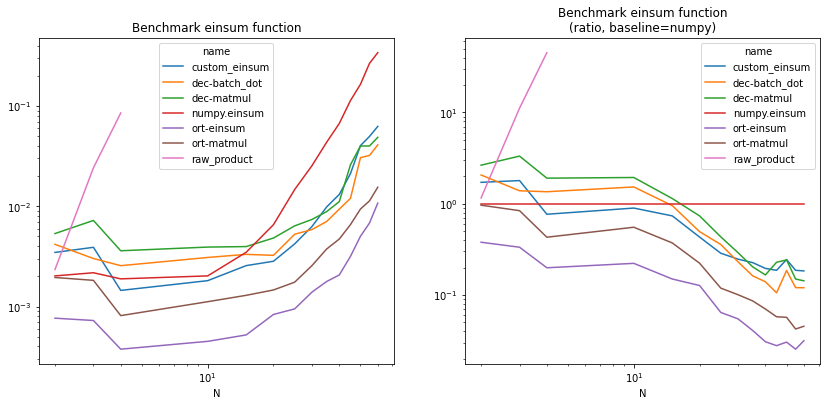

In [16]:
import matplotlib.pyplot as plt

piv = df.pivot("N", "name", "average")
piv2 = piv.copy()
np = piv["numpy.einsum"]
for c in piv2.columns:
    piv2[c] /= np
    
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax[0])
ax[0].set_title("Benchmark einsum function")
piv2.plot(logy=True, logx=True, ax=ax[1])
ax[1].set_title("Benchmark einsum function\n(ratio, baseline=numpy)");

Version `dec-matmul` is an implementation based on the decomposition of a simplified einsum into a sequence of transpose, reshape, (batch_)dot or mul operations. This decomposition is converted into ONNX and executed with *onnxruntime*, version `ort-matmul`. Both version are faster than the numpy optimized version. The ONNX graph may contain consecutive transpose which should be merged.

## Another example with `bsnh,btnh->bnts`

Another case, more frequent in deep learning.

### Decomposition of `bsnh,btnh->bnts`

In [17]:
seq2 = decompose_einsum_equation("bsnh,btnh->bnts", strategy='numpy', clean=True)
RenderJsDot(seq_clean.to_dot(size=7))

### ONNX version

In [18]:
onx2 = seq2.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
%onnxview onx2 

### Benchmark

In [19]:
equation = "bsnh,btnh->bnts"
sess = None
sess2 = None
seq = None 


def make_model2(equation):
    model = helper.make_model(
        opset_imports=[helper.make_operatorsetid('', 13)],
        graph=helper.make_graph(
            name='einsum_test',
            inputs=[helper.make_tensor_value_info("X", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Y", onnx.TensorProto.FLOAT, None)],
            outputs=[helper.make_tensor_value_info("A", onnx.TensorProto.FLOAT, None)],
            nodes=[
                helper.make_node("Einsum", ["X", "Y"], ["A"], equation=equation)
            ]
        )
    )
    return model


results = []
for N in tqdm([2, 3, 4, 10, 20, 30, 40]):
    m1 = numpy.random.randn(10, N, N, N)
    m2 = numpy.random.randn(10, N, N, N)
    
    if seq is None:
        seq = decompose_einsum_equation(equation, clean=True)
    if seq2 is None:
        seq2 = decompose_einsum_equation(equation, clean=True, strategy='numpy')
    if sess is None:
        model = make_model2(equation)
        sess = InferenceSession(model.SerializeToString())
    if sess2 is None:
        onx = seq2.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
        sess2 = InferenceSession(onx.SerializeToString())

    res = measure_time(lambda x: numpy.einsum(equation, *x, optimize=True),
                       [m1, m2],
                       repeat=10, number=10)
    
    res['name'] = "numpy.einsum"
    res["N"] = N
    results.append(res)

    res = measure_time(lambda x: apply_einsum_sequence(seq, *x),
                       [m1, m2],
                       repeat=10, number=10)
    res['name'] = "custom_einsum"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq, *x, matmul_impl="pyf"),
                       [m1, m2],
                       repeat=10, number=10)
    res['name'] = "dec-matmul"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq2, *x, matmul_impl="pyf"),
                       [m1, m2],
                       repeat=10, number=10)
    res['name'] = "dec-batch_dot"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: sess.run(None, {'X': x[0], 'Y': x[1]}),
                       [m1.astype(numpy.float32), m2.astype(numpy.float32),
                        m3.astype(numpy.float32)],
                       repeat=10, number=10)
    res['name'] = "ort-einsum"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: sess2.run(None, {'X1': x[0], 'X2': x[1]}),
                       [m1.astype(numpy.float32), m2.astype(numpy.float32),
                        m3.astype(numpy.float32)],
                       repeat=10, number=10)
    res['name'] = "ort-matmul"
    res["N"] = N
    results.append(res)    
    

df = DataFrame(results)
df.tail()

100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N
37,0.214270,0.008312,0.206204,0.232551,10,10,2.142702,custom_einsum,40
38,0.149143,0.006786,0.139158,0.159905,10,10,1.491428,dec-matmul,40
39,0.098974,0.003514,0.096620,0.105941,10,10,0.989736,dec-batch_dot,40
40,0.048014,0.003182,0.045956,0.054360,10,10,0.480141,ort-einsum,40
41,0.063143,0.003305,0.059782,0.070504,10,10,0.631427,ort-matmul,40


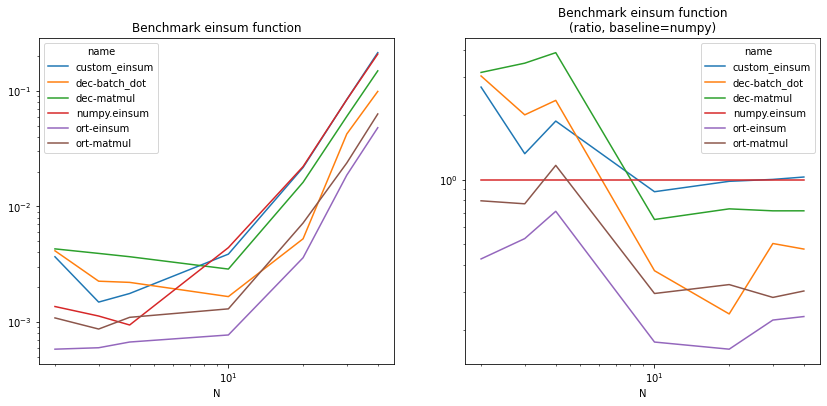

In [20]:
piv = df.pivot("N", "name", "average")
piv2 = piv.copy()
np = piv["numpy.einsum"]
for c in piv2.columns:
    piv2[c] /= np
    
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax[0])
ax[0].set_title("Benchmark einsum function")
piv2.plot(logy=True, logx=True, ax=ax[1])
ax[1].set_title("Benchmark einsum function\n(ratio, baseline=numpy)");

### Permutation

Einsum's algorithm started by aligning all matrices involved in the computation to the same dimension in the same order. But which order is the best, that's the question.

In [21]:
equation = "bsnh,btnh->bnts"
letters = list(sorted(set([c for c in equation if "a" <= c < "z"])))
letters

['b', 'h', 'n', 's', 't']

In [22]:
from itertools import permutations

N = 20
m1 = numpy.random.randn(N, N, N, N)
m2 = numpy.random.randn(N, N, N, N)

results = []
for perm in tqdm(list(permutations(letters))):
    replace = {d: c for c, d in zip(letters, perm)}
    eq = equation
    for k, v in replace.items():
        eq = eq.replace(k, v.upper())
    eq = eq.lower()
    
    seq = decompose_einsum_equation(eq, clean=True)
    seq2 = decompose_einsum_equation(eq, clean=True, strategy='numpy')
    model = make_model2(eq)
    sess = InferenceSession(model.SerializeToString())
    onx = seq2.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
    sess2 = InferenceSession(onx.SerializeToString())
    
    res = measure_time(lambda x: numpy.einsum(eq, *x, optimize=True),
                       [m1, m2],
                       repeat=5, number=5)
    
    res['name'] = "numpy.einsum"
    res["N"] = N
    res["eq"] = eq
    results.append(res)
    
    res = measure_time(lambda x: apply_einsum_sequence(seq, *x),
                       [m1, m2],
                       repeat=5, number=5)
    res['name'] = "custom_einsum"
    res["N"] = N
    res["eq"] = eq
    results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq, *x, matmul_impl="pyf"),
                       [m1, m2],
                       repeat=5, number=5)
    res['name'] = "dec-matmul"
    res["N"] = N
    res["eq"] = eq
    results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq2, *x, matmul_impl="pyf"),
                       [m1, m2],
                       repeat=5, number=5)
    res['name'] = "dec-batch_dot"
    res["N"] = N
    res["eq"] = eq
    results.append(res)    

    res = measure_time(lambda x: sess.run(None, {'X': x[0], 'Y': x[1]}),
                       [m1.astype(numpy.float32), m2.astype(numpy.float32),
                        m3.astype(numpy.float32)],
                       repeat=5, number=5)
    res['name'] = "ort-einsum"
    res["N"] = N
    res["eq"] = eq
    results.append(res)    

    res = measure_time(lambda x: sess2.run(None, {'X1': x[0], 'X2': x[1]}),
                       [m1.astype(numpy.float32), m2.astype(numpy.float32),
                        m3.astype(numpy.float32)],
                       repeat=5, number=5)
    res['name'] = "ort-matmul"
    res["N"] = N
    res["eq"] = eq
    results.append(res)    
    

df = DataFrame(results)
df.tail()

100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N,eq
715,0.023706,0.001049,0.022805,0.025733,5,5,0.118531,custom_einsum,20,"thns,tbns->tnbh"
716,0.016400,0.000091,0.016298,0.016568,5,5,0.081999,dec-matmul,20,"thns,tbns->tnbh"
717,0.011034,0.000054,0.010932,0.011090,5,5,0.055171,dec-batch_dot,20,"thns,tbns->tnbh"
718,0.003439,0.000130,0.003335,0.003659,5,5,0.017194,ort-einsum,20,"thns,tbns->tnbh"
719,0.004802,0.000054,0.004719,0.004864,5,5,0.024009,ort-matmul,20,"thns,tbns->tnbh"


In [23]:
df = df.sort_values("average").reset_index(drop=True)
df.head()

,average,deviation,min_exec,max_exec,repeat,number,total,name,N,eq
0,0.002331,0.000039,0.002306,0.002409,5,5,0.011657,ort-matmul,20,"bhst,bnst->bsnh"
1,0.002349,0.000052,0.002315,0.002451,5,5,0.011743,ort-matmul,20,"hnst,hbst->hsbn"
2,0.002365,0.000059,0.002310,0.002441,5,5,0.011823,ort-matmul,20,"hsnt,hbnt->hnbs"
3,0.002366,0.000041,0.002328,0.002426,5,5,0.011828,ort-matmul,20,"bhts,bnts->btnh"
4,0.002388,0.000058,0.002348,0.002500,5,5,0.011941,ort-matmul,20,"bhnt,bsnt->bnsh"


In [24]:
df.tail()

,average,deviation,min_exec,max_exec,repeat,number,total,name,N,eq
715,0.031834,0.005069,0.027032,0.041379,5,5,0.159171,custom_einsum,20,"hnbt,hsbt->hbsn"
716,0.032910,0.003853,0.026787,0.038817,5,5,0.164551,custom_einsum,20,"bsnh,btnh->bnts"
717,0.032930,0.013094,0.023331,0.056991,5,5,0.164648,custom_einsum,20,"shtb,sntb->stnh"
718,0.032959,0.002867,0.027536,0.035396,5,5,0.164794,numpy.einsum,20,"htbs,hnbs->hbnt"
719,0.035608,0.001795,0.033823,0.038916,5,5,0.178038,numpy.einsum,20,"hnbt,hsbt->hbsn"


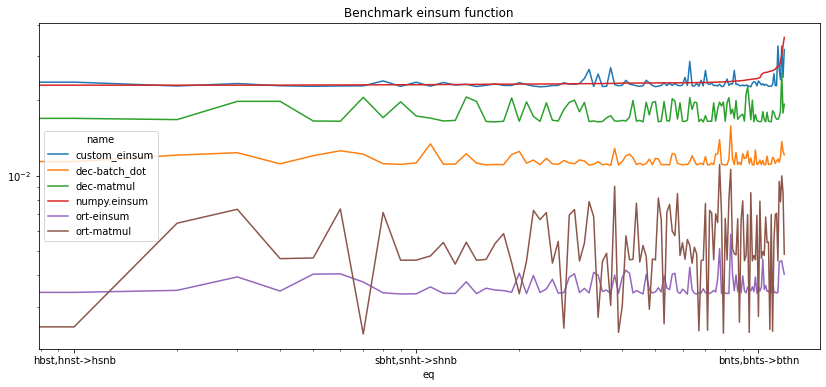

In [25]:
piv = df.pivot("eq", "name", "average").sort_values("numpy.einsum")
    
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax)
ax.set_title("Benchmark einsum function");